# Import libraries

In [17]:
!pip install -q git+https://github.com/tensorflow/docs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [18]:
# OPTIONAL: run the cell below if you are on google colab
from google.colab import drive
drive.mount('/content/drive')

import os 

curr_dir = os.path.split(os.getcwd())[1]
print(f"Current directory: {curr_dir}")
if curr_dir != 'Machine Learning':
  os.chdir('drive/MyDrive/Programming/freeCodeCamp/Machine Learning')
  print(f"Changed directory to: {os.path.split(os.getcwd())[1]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: Machine Learning


# Data Processing

## Read data

In [19]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.head()

--2022-11-08 20:04:18--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.2’

insurance.csv.2     100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2022-11-08 20:04:18 (4.75 MB/s) - ‘insurance.csv.2’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [20]:
# exploring the dataset
print("The dataset has", len(dataset), "rows")
print("Columns (features of the dataset):")
print(list(dataset.columns))

The dataset has 1338 rows
Columns (features of the dataset):
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses']


## Clean

In [21]:
dataset_clean = dataset.copy(deep=True)

# Check how many null values there are
dataset_clean.isna().sum()
# There are no missing values, so no need to handle missing values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

## Preprocessing

In [22]:
# First of all, all the features seem relevant for prediction, so we'll keep them in. 

In [23]:
# Dealing with categorical data
"""
There are some categorical variables in the dataset:
- sex
- smoker
- region
Let's process them by one-hot encoding
"""
dataset_preprocess = dataset_clean.copy(deep=True)

for i in ['sex', 'smoker', 'region']:
  print(f"Unique categories in variable '{i}': {dataset_preprocess[i].unique()}")
print('-'*100)

# one-hot encode 'sex'
dataset_preprocess = pd.get_dummies(dataset_preprocess, columns=['sex'], prefix='', prefix_sep='')
# one-hot encode 'smoker'
dataset_preprocess['smoker'] = dataset_preprocess['smoker'].map({'yes':'smoking', 'no':'no_smoking'})
dataset_preprocess = pd.get_dummies(dataset_preprocess, columns=['smoker'], prefix='', prefix_sep='')
# one-hot encode 'region'
dataset_preprocess = pd.get_dummies(dataset_preprocess, columns=['region'], prefix='', prefix_sep='')
dataset_preprocess.head()

Unique categories in variable 'sex': ['female' 'male']
Unique categories in variable 'smoker': ['yes' 'no']
Unique categories in variable 'region': ['southwest' 'southeast' 'northwest' 'northeast']
----------------------------------------------------------------------------------------------------


,age,bmi,children,expenses,female,male,no_smoking,smoking,northeast,northwest,southeast,southwest
0,19,27.9,0,16884.92,1,0,0,1,0,0,0,1
1,18,33.8,1,1725.55,0,1,1,0,0,0,1,0
2,28,33.0,3,4449.46,0,1,1,0,0,0,1,0
3,33,22.7,0,21984.47,0,1,1,0,0,1,0,0
4,32,28.9,0,3866.86,0,1,1,0,0,1,0,0


## Train-test split

In [24]:
from sklearn.model_selection import train_test_split

data = dataset_preprocess.copy(deep=True)

# Features-labels split and train-validation split
# Features - all the columns except "expenses"
features = data.drop(['expenses'], axis=1)
labels = data['expenses']

# Split the data into test-train-validation sets: 60-20-20%
## First split the data into two groups: one with train data, the other - with mixed test and validate
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
	features, labels, test_size=0.4, 
	random_state=100 # We fix random_state to make sure we get the same split every time
)
## Now, split the test-validate group into the separate test and validate groups
features_validation, features_test, labels_validation, labels_test = train_test_split(
	features_validation_test, labels_validation_test, test_size=0.5, random_state=100
)
print(f"For training, we will use {len(features_train)} features and {len(labels_train)} labels.")
print(f"For validation, we will use {len(features_validation)} features and {len(labels_validation)} labels.")
print(f"For testing, we will use {len(features_test)} features and {len(labels_test)} labels.")

For training, we will use 802 features and 802 labels.
For validation, we will use 268 features and 268 labels.
For testing, we will use 268 features and 268 labels.


In [25]:
print(len(features_train.columns))
features_train.head()

11


,age,bmi,children,female,male,no_smoking,smoking,northeast,northwest,southeast,southwest
1025,21,34.6,0,1,0,1,0,0,0,0,1
253,27,30.3,3,0,1,1,0,0,0,0,1
359,18,20.8,0,1,0,1,0,0,0,1,0
1231,20,21.8,0,1,0,0,1,0,0,0,1
1176,52,24.1,1,1,0,0,1,0,1,0,0


# Train (sklearn)

In [26]:
def print_output(model, model_name:str):
  model.fit(features_train, labels_train)
  print(f"Model: {model_name}")
  predictions = model.predict(features_validation)
  print(f" - Mean Absolute Error: {mean_absolute_error(labels_validation, predictions):.0f}")
  print('-'*50)

models_list = [
    [LinearRegression(), 'Linear Regression'],
    [Lasso(), 'Lasso Regression'], 
    [DecisionTreeRegressor(max_depth=2), 'Decision Tree Regression']
]

for i, j in models_list:
  print_output(i, j)



Model: Linear Regression
 - Mean Absolute Error: 3953
--------------------------------------------------
Model: Lasso Regression
 - Mean Absolute Error: 3953
--------------------------------------------------
Model: Decision Tree Regression
 - Mean Absolute Error: 3352
--------------------------------------------------


# Train (tensorflow)

In [27]:
tf.random.set_seed(42)

model = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_absolute_error',
    optimizer='adam',
    metrics=['mean_absolute_error']
)

model.fit(features_train, labels_train, epochs=100)

Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 13314.4453 - mean_absolute_error: 13314.4453
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 12102.9023 - mean_absolute_error: 12102.9023
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 8370.7832 - mean_absolute_error: 8370.7832
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 7621.8506 - mean_absolute_error: 7621.8506
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 7517.7886 - mean_absolute_error: 7517.7886
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 7439.7842 - mean_absolute_error: 7439.7842
Epoch 7/100
26/26 [==============================] - 0s 9ms/step - loss: 7355.5713 - mean_absolute_error: 7355.5713
Epoch 8/100
26/26 [==============================] - 0s 8ms/step - loss: 7252.5068 - mean_absolute_error: 7252.5068
Epoch 9/100
26/26 [==============================] - 0s 9ms/step - l

In [28]:
model.evaluate(features_validation, labels_validation)

9/9 [==============================] - 0s 3ms/step - loss: 2828.2305 - mean_absolute_error: 2828.2305


[2828.23046875, 2828.23046875]

# pre-test

In [29]:
test_dataset = features_test
test_labels = labels_test

In [30]:
values = model.evaluate(test_dataset, test_labels, verbose=2)
print(values[0])
print(values[1])

9/9 - 0s - loss: 2978.8103 - mean_absolute_error: 2978.8103 - 39ms/epoch - 4ms/step
2978.810302734375
2978.810302734375


# Test 

9/9 - 0s - loss: 2978.8103 - mean_absolute_error: 2978.8103 - 36ms/epoch - 4ms/step
Testing set Mean Abs Error: 2978.81 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


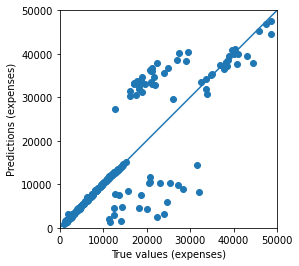

In [31]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
# loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)
mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
